# ДЗ 1
## Классический МЛ в NLP, вспомнить все!

В этом ДЗ будем работать с датасетом Men_Women_Shoes_Reviews ttps://www.kaggle.com/daishinkan002/men-women-shoes-reviews 
 

### **Задание 1**. 
Предсказать цену по описанию товара (для каждого товара)
### **Задание 2.** 
Предсказать оценку товара пользователем по его отзыву (для каждого отзыва)

## *Что нужно сделать в каждом задании:* 
1) проанализировать данные (все, на что хватит вашей фантазии, хороший анализ включает в себя графики и статистические инструменты анализа, можно приходить с вопросами "какой инструмент поможет мне проверить такую-то гипотезу/хочу посмотреть вот это вот, как это сделать", предварительно не стесняйтесь гуглить) **1 балл**

2) подготовить данные (стемминг, лемматизация, убрать мусор и стоп-слова, нормализовать... все, что покажется вам разумным относительно данных, но вы должны кратко (комментарием к этому блоку кода в тетрадке) объяснить почему вы сделали именно такой препроцессинг. Хороший препроцессинг - разумный, в данном случае чем больше тем не всегда лучше) **1 балла**

3) векторизовать тексты (контекстуальные эммбединги пока что не берем, только BoW и TF-IDF) **0.5 балл**

4) сделать гридсерч по нескольким моделям (у нас 2 задания, классификация и регрессия), подобрать гиперпараметры, выбрать лучшую модель, рассказать, почему, на ваш взгляд,лучший результат показал лучший алгоритм **1 балл**

5) оценить и проанализировать качество лучших решений для каждой задачи (рассказать с чем ваша модель справляется хорошо, а где у нее "слабые места", можно ли как-то улучшить ваши результаты. Хороший анализ сопровождается графиками) **1,5 балла** 

Максимальная сумма баллов при выполнении 5 пунктов в 2 заданиях - 10

В тетрадке с первого занятия много дополнительной информации, которая может вам помочь, но все равно не стесняйтесь приходить с вопросами в чат курса. 

# Загрузка и обработка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import *
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR, LinearSVC
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack
%matplotlib inline

nlp = spacy.load('en')
nltk.download(['stopwords', 'punkt'])
ps = PorterStemmer()
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
db = pd.read_csv('Shoes_Data.csv')

In [3]:
db['price'] = [float(i[1:]) for i in db['price']]
db['rating'] = [float(re.search('[\d\.]+', i).group(0)) for i in db['rating']]
db['total_reviews'] = [int(re.search('[\d\.]+', i).group(0)) for i in db['total_reviews']]

#Регрессия

## Статистика

1. Достаточно много выбросов, средняя цена где-то 1,5к.

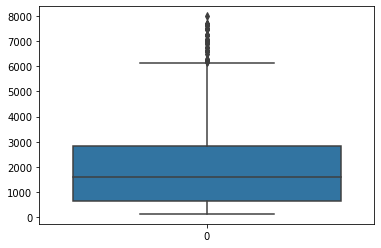

In [ ]:
ax = sns.boxplot(data=db['price'])

2. Посмотрим, как влияет пол владельца на цену.

Можно заметить, что у женщин больше средний диапазон цен на обувь и средняя цена выше, однако у мужчин относительно много выбросов с очень высокими ценами. Так же стоит отметить, что мужской обуви в принципе в 2 раза больше, чем женской. Поскольку различия, на мой взгляд, достаточно большие, то стоит учитывать этот признак.

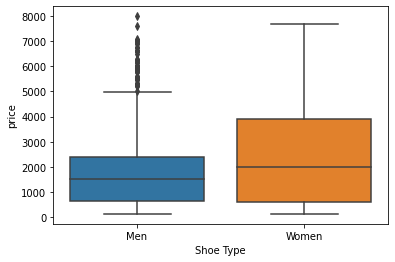

In [ ]:
ax = sns.boxplot(x='Shoe Type', y='price', data=db)

In [ ]:
print(db['Shoe Type'][db['Shoe Type'] == 'Men'].count())
print(db['Shoe Type'][db['Shoe Type'] == 'Women'].count())

856
374


3. Также можно посмотреть, как цена зависит от среднего рейтинга. У мужчин чуть более ровная зависимость: чем больше рейтинг, тем больше цена. У женщин все чуть сложнее, возможно, это из-за того, что женской обуви в принципе меньше. Этот признак также можно взять для обучения.

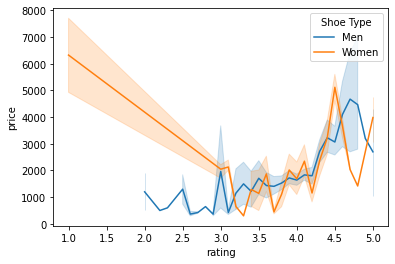

In [ ]:
ax = sns.lineplot(data=db, x='rating', y = 'price', hue='Shoe Type')

In [4]:
db['Shoe Type'][db['Shoe Type'] == 'Men'] = 0.0
db['Shoe Type'][db['Shoe Type'] == 'Women'] = 1.0
db['len_descs'] = [len(desc.split()) for desc in db['product_description']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


4. Посмотрим на корреляцию. Для мужчин можно увидеть, что есть небольшая корреляция между ценой и рейтингом, у женщин же наибольшая корреляция между ценой и количеством отзывов.

In [ ]:
db[db['Shoe Type'] == 0.0].corr()

,price,rating,total_reviews,len_descs
price,1.000000,0.303264,-0.143885,0.190974
rating,0.303264,1.000000,0.059785,0.075601
total_reviews,-0.143885,0.059785,1.000000,0.033492
len_descs,0.190974,0.075601,0.033492,1.000000


In [ ]:
db[db['Shoe Type'] == 1.0].corr()

,price,rating,total_reviews,len_descs
price,1.000000,0.097977,0.178466,0.055357
rating,0.097977,1.000000,0.128121,0.003074
total_reviews,0.178466,0.128121,1.000000,-0.024974
len_descs,0.055357,0.003074,-0.024974,1.000000


## Предобработка текстов (для обоих заданий одинаковая)

Препроцессинг: 

1) Лемматизация 

Не стеминг, поскольку он менее точный, а данных не так много, поэтому разница в скорости здесь не критична.

2) Очистка от пунктуации, кроме ! и ? (кажется, они могут нести какую-то эмоциональную окраску, поэтому решила их оставить), и стоп-слов (в данном случае нам они не дадут необходим0й информации). Числа решила оставить, поскольку они здесь могут давать информацию (например, цена может быть прописана в описании или какая-нибудь комплектация. Если говорить об отзывах, то также люди нередко прописывают свою оценку)

In [226]:
def lemma_preprocess_text(text):
  text = [token.lemma_ for token in nlp(text) if (not token.is_punct or str(token) in ['!', '?']) and not token.is_stop]
  return ' '.join(text)

descs = [lemma_preprocess_text(text) for text in db['product_description']]

## Обучение и предсказание

Модели: ридж, svr и sdg. Ридж и SVR хорошо работают с выбросами, поэтому взяла его. Лассо и Эластикнет работали медленно, поэтому от них отказалась и решила еще посмотреть на sdgregressor. Тфидф работает лучше, чем каунтвекторайзер, поэтому использовала его.

In [227]:
cv = CountVectorizer(max_features=1000, min_df=5, max_df=0.4, ngram_range=(1,2))
tfidf = TfidfVectorizer(max_features=2000, min_df=5,analyzer='word', ngram_range=(1,2), max_df=0.5)

def vectorize(vect, texts):
  texts = vect.fit_transform(texts)
  return texts

count_text = vectorize(cv, descs)
tfidf_text = vectorize(tfidf, descs)
features = hstack([tfidf_text, np.expand_dims(db['Shoe Type'].to_numpy(dtype=np.float64), axis=1),
                   np.expand_dims(db['rating'].to_numpy(dtype=np.float64), axis=1)])

In [240]:
mae = make_scorer(mean_absolute_error,greater_is_better=False)
X_train, X_test, y_train, y_test = train_test_split(features, db['price'].to_numpy(), random_state=42, stratify=db['Shoe Type'])
mod_params = {'Ridge': [Ridge(random_state=42), {'alpha': [0.001, 0.01, 0.1, 0.5, 1]}],
              'SVR': [SVR(kernel='linear'), {'C': [500, 1000, 2000, 3000, 4000, 5000]}],
              'SGDRegressor':[SGDRegressor(random_state=42, max_iter=10000), {'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                                                              'penalty': ['l1', 'l2', 'elasticnet'],
                                                              'alpha': [0.001, 0.01, 0.1, 0.5, 1],
                                                              }]}
for model, params in mod_params.items():
  grid_search = GridSearchCV(params[0], param_grid=params[1], scoring=mae, n_jobs=-1, refit=True)
  grid_search.fit(X_train, y_train)
  print('{} best train score: {}'.format(model, grid_search.best_score_))
  print('{} best parameters: {}'.format(model, grid_search.best_params_))
  print('{} test score: {}'.format(model, grid_search.score(X_test, y_test)))

Ridge best train score: -646.5556324249139
Ridge best parameters: {'alpha': 0.1}
Ridge test score: -640.0985714143562
SVR best train score: -602.9896005320301
SVR best parameters: {'C': 3000}
SVR test score: -607.7697497203176
SGDRegressor best train score: -800.912034522763
SGDRegressor best parameters: {'alpha': 0.001, 'loss': 'squared_epsilon_insensitive', 'penalty': 'l1'}
SGDRegressor test score: -729.4153489871427


Лучше всего работает svr, это неудивительно, учитывая его работу с выбросами. На 2 месте - ридж, он тоже неплохо работает с выбросами. А вот хуже всего - sgd, потому что он наиболее чувствителен к выбросам

In [241]:
model = SVR(kernel='linear', C=3000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
importance = model.coef_

Еще можно посмотреть на r2, оно около 0.5, не так уж и плохо для регрессии

In [242]:
r2_score(y_pred, y_test)

0.5205270210638128

##Визуализация результатов
Средний диапазон примерно одинаков (чуть меньше на тесте, вероятно, это влияние выбросов), однако в тесте слишком много выбросов с большими ценами. Наша же модель эти выбросы находит хуже (возможно, это можно считать в некоторой степени за плюс, она не переобучилась)

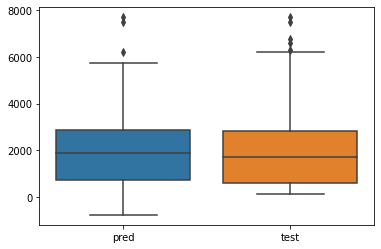

In [243]:
y_df = pd.DataFrame()
y_df['pred'] = y_pred
y_df['test'] = y_test
sns.boxplot(data=y_df)

Посмотрим на важные признаки. Веса у важных признаков получились достаточно большие. В топ-10 признаков входят достаточно специфичные для темы обуви слова - фирмы(найк, адидас, конверс), например. У меня немного выбиваются из картины grip и react, но может я просто не знаю особенностей английских описаний обуви.

In [254]:
importance = importance.toarray()[0]

<BarContainer object of 2002 artists>

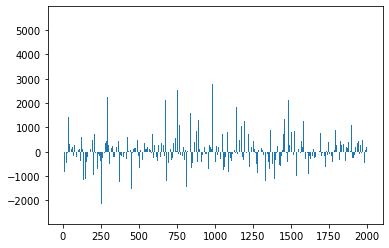

In [257]:
plt.bar([x for x in range(len(importance))], importance)

In [258]:
feats = tfidf.vocabulary_
feats['GENDER'] = 2000
feats['RATING'] = 2001

In [261]:
voc = sorted(feats, key=lambda x: feats[x])
absim = [abs(x) for x in importance]
order = np.argsort(absim)[::-1]
top = []
for i in order:
    top.append((voc[i], importance[i]))
print(top[:10])

[('nike', 5566.732706629223), ('converse', 3409.2702135279815), ('adidas', 3327.5762540916558), ('badminton', 3259.232409901722), ('midsole cushion', 2766.5354937362226), ('react', 2704.896786636772), ('game', 2692.9285772642875), ('responsive', 2676.601309196452), ('quality material', 2667.6277832507376), ('grip', -2555.0043579757257)]


Рейтинг и пол оказались не очень важными признаками

In [259]:
importance[2000:]

array([282.06414517,  71.12404036])

# Классификация

## Преобразование к удобному формату

In [262]:
reviews = [revs.split('||') for revs in db['reviews']]
rev_rating = []
for rats in db['reviews_rating']:
  rev_rating.append([float(re.search('[\d\.]+', i).group(0)) for i in rats.split('||')])

In [263]:
ids = []
rews =[]
rats = []
for i, revs in enumerate(reviews):
  for j, rev in enumerate(revs):
    ids.append(i)
    rews.append(rev)
    rats.append(rev_rating[i][j])
rev_df = pd.DataFrame({'id': ids, 'review': rews, 'rev_rating': rats})

In [264]:
db['id'] = range(len(db['title']))

In [265]:
full_df = rev_df.merge(db, on='id')

In [266]:
full_df['len_rev'] = [len(rev.split()) for rev in full_df['review']]

##Статистика

А здесь уже очень большая разница между мужчинами и женщинами, женщины намного реже ставят низкие оценки. Кроме того, выбросов в этих данных уже не так много

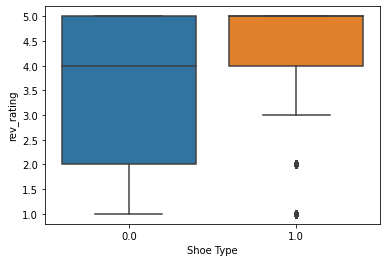

In [267]:
ax = sns.boxplot(x='Shoe Type', y='rev_rating', data=full_df)

С ценой закономерности не наблюдается

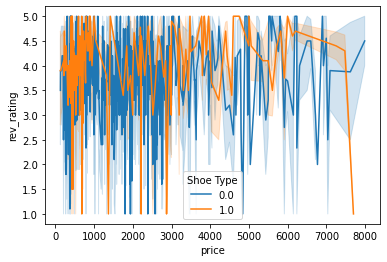

In [268]:
ax = sns.lineplot(data=full_df, x='price', y = 'rev_rating', hue='Shoe Type')

Ни у мужчин, ни у женщин нет никаких сильно коррелирующих с оценкой признаков, поэтому кроме пола и самих отзывов другие признаки брать не будем

In [128]:
full_df[full_df['Shoe Type'] == 0.0].corr()

,id,rev_rating,price,rating,total_reviews,len_descs,len_rev
id,1.000000,0.056578,0.837966,0.441880,-0.166275,0.137544,-0.059676
rev_rating,0.056578,1.000000,0.060053,0.237955,0.014776,0.007076,-0.140487
price,0.837966,0.060053,1.000000,0.393598,-0.151926,0.226405,-0.069313
rating,0.441880,0.237955,0.393598,1.000000,0.060029,0.112273,-0.028281
total_reviews,-0.166275,0.014776,-0.151926,0.060029,1.000000,0.034634,0.120944
len_descs,0.137544,0.007076,0.226405,0.112273,0.034634,1.000000,-0.031301
len_rev,-0.059676,-0.140487,-0.069313,-0.028281,0.120944,-0.031301,1.000000


In [129]:
full_df[full_df['Shoe Type'] == 1.0].corr()

,id,rev_rating,price,rating,total_reviews,len_descs,len_rev
id,1.000000,0.085719,0.917187,0.405477,0.156291,0.098546,-0.155219
rev_rating,0.085719,1.000000,0.084670,0.267607,0.051285,0.032808,-0.179284
price,0.917187,0.084670,1.000000,0.402347,0.203738,0.050038,-0.158966
rating,0.405477,0.267607,0.402347,1.000000,0.184504,0.044757,-0.103069
total_reviews,0.156291,0.051285,0.203738,0.184504,1.000000,-0.027894,-0.018755
len_descs,0.098546,0.032808,0.050038,0.044757,-0.027894,1.000000,0.005732
len_rev,-0.155219,-0.179284,-0.158966,-0.103069,-0.018755,0.005732,1.000000


In [130]:
full_df.corr()

,id,rev_rating,price,rating,total_reviews,len_descs,len_rev
id,1.000000,0.138722,0.607608,0.411751,-0.078213,0.180392,-0.150013
rev_rating,0.138722,1.000000,0.091442,0.264831,0.022083,0.031336,-0.164040
price,0.607608,0.091442,1.000000,0.418997,-0.015105,0.174146,-0.121311
rating,0.411751,0.264831,0.418997,1.000000,0.093233,0.115307,-0.075491
total_reviews,-0.078213,0.022083,-0.015105,0.093233,1.000000,0.012589,0.086448
len_descs,0.180392,0.031336,0.174146,0.115307,0.012589,1.000000,-0.038527
len_rev,-0.150013,-0.164040,-0.121311,-0.075491,0.086448,-0.038527,1.000000


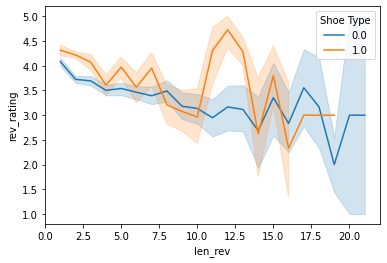

In [131]:
ax = sns.lineplot(data=full_df, x='len_rev', y = 'rev_rating', hue='Shoe Type')

Датасет очень несбалансированный, слишком много высоких оценок.

In [193]:
full_df['rev_rating'].value_counts()

5.0    4944
4.0    1853
1.0    1749
3.0     863
2.0     549
Name: rev_rating, dtype: int64

##Предобработка данных

In [269]:
reviews = [lemma_preprocess_text(text) for text in full_df['review']]

## Обучение и предсказание

In [270]:
cv = CountVectorizer(max_features=2000, min_df=3, max_df=0.7, ngram_range=(1,2))
tfidf = TfidfVectorizer(max_features=2000, min_df=3,analyzer='word', ngram_range=(1,3), max_df=0.7)

def vectorize(vect, texts):
  texts = vect.fit_transform(texts)
  return texts

count_text = vectorize(cv, reviews)
tfidf_text = vectorize(tfidf, reviews)
features = hstack([tfidf_text, np.expand_dims(full_df['Shoe Type'].to_numpy(dtype=np.float64), axis=1)])

Для классификации я взяла MultinomialNB (т.к. он неплохо работает с текстами), а также LinearSVC и RandomForest, которые в принципе хороши для классификации, ипокольку данных не так много, ждать приходится не так долго.

In [278]:
X_train, X_test, y_train, y_test = train_test_split(features, full_df['rev_rating'].to_numpy(), random_state=42, stratify=full_df['rev_rating'])
mod_params = {'LinearSVC': [LinearSVC(random_state=42, class_weight='balanced'), {'penalty': ['l1', 'l2'], 'C': [1, 2, 3],
                                                         'loss': ['hinge', 'squared_hinge'], 'multi_class': ['ovr', 'crammer_singer']}],
              'MultinomialNB': [MultinomialNB(), {'alpha': [0, 0.001, 0.01, 0.1, 0.5, 1, 10, 100, 500]}],
              'RandomForestClassifier': [RandomForestClassifier(random_state=42), {'n_estimators': [50, 100, 150, 200], 'criterion': ['gini', 'entropy'],
                                                                                   'max_depth': [None, 100, 200, 500, 1000]}]
              }
for model, params in mod_params.items():
  grid_search = GridSearchCV(params[0], param_grid=params[1], scoring='balanced_accuracy', n_jobs=-1, refit=True)
  grid_search.fit(X_train, y_train)
  print('{} best train score: {}'.format(model, grid_search.best_score_))
  print('{} best parameters: {}'.format(model, grid_search.best_params_))
  print('{} test score: {}'.format(model, grid_search.score(X_test, y_test)))

LinearSVC best train score: 0.4566196088014108
LinearSVC best parameters: {'C': 1, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
LinearSVC test score: 0.4452287836066683
MultinomialNB best train score: 0.4330287859720829
MultinomialNB best parameters: {'alpha': 0.01}
MultinomialNB test score: 0.4193062875406984
RandomForestClassifier best train score: 0.4411086424722286
RandomForestClassifier best parameters: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 50}
RandomForestClassifier test score: 0.4331677359215444


Все модели дают примерно одинаковый результат, лучшей оказалась LinearSVC.

In [279]:
model = LinearSVC(loss='squared_hinge', multi_class='ovr', penalty='l2', random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
predicted = model.predict(X_test)

Качество получилось не очень хорошим. Это может быть из-за того, что у нас очень несбалансированный датасет.

In [280]:
acc = accuracy_score(predicted, y_test)
micro_f1 = f1_score(predicted, y_test, average = 'micro')
micro_p = precision_score(predicted, y_test, average = 'micro')
micro_r = recall_score(predicted, y_test, average = 'micro')
macro_f1 = f1_score(predicted, y_test, average = 'macro')
macro_p = precision_score(predicted, y_test, average = 'macro')
macro_r = recall_score(predicted, y_test, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.5859
micro F1=0.5859, micro P=0.5859, micro R=0.5859
macro F1=0.4518, macro P=0.4452, macro R=0.4623



## Визуализация

Относительно хорошо предсказывается оценки 1 и 5, вероятно потому, что, во-первых, это крайние оценки и отзывы к ним, наверное, наиболее эмоцианально окрашены. Кроме того, оценка 5 в нашем датасете самая распространенная, а вот, например, 2 и 3 очень мало, и они предсказываются плохо. 4 часто путается с 5, в принципе, это тоже объяснимо, поскольку отзывы в обоих случаях обычно достаточно положительные и похожие. Для улучшения работы моделей стоит как-то попытаться побороться с несбалансированным датасетом. Можно, например, выкинуть какое-то количество положительных отзывов.

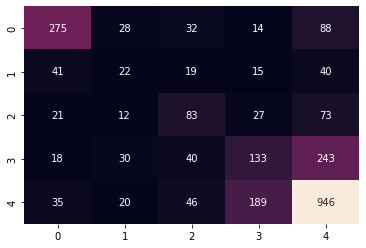

In [281]:
sns.heatmap(data=confusion_matrix(y_test, predicted), annot=True, fmt="d", cbar=False)

Самые важные признаки для каждого класса очень показательны, везде явно видна позитивная/негативная окраска.

In [282]:
importance = model.coef_

In [283]:
feats = tfidf.vocabulary_
feats['GENDER'] = len(feats)

In [284]:
voc = sorted(feats, key=lambda x: feats[x])
for class_im in importance:
  print(class_im[feats['GENDER']])
  absim = [abs(x) for x in class_im]
  order = np.argsort(absim)[::-1]
  top = []
  for i in order:
      top.append((voc[i], class_im[i]))
  print(top[:10])

-0.11427063232398613
[('waste', 2.207139711076623), ('refund', 2.0475847556264912), ('plastic', 1.8030890597107976), ('good shoe', -1.7968046699077576), ('duplicate', 1.7449920605998588), ('worst', 1.7376206238576883), ('not buy', 1.7045063167213144), ('leg', 1.6475357381416857), ('properly', 1.6170965969504794), ('bed', 1.6074618623178838)]
-0.0609360082113108
[('shoe tight', 2.4274687936132016), ('reject product', 2.1157980104057503), ('ok ok product', 2.0959061623923554), ('size buy', 2.0622570769502904), ('usual', 2.0562203022105723), ('genuine leather', 2.048121495456967), ('shoe get', -2.034993362856766), ('wrong colour', 2.012057637625961), ('sole soft', 1.9429251813159703), ('product amazon', 1.8937478172043707)]
-0.02968939492300817
[('waise', 2.3035158272821263), ('skechers', 2.1039163863349697), ('ok bad', 2.097821463748279), ('cost high', 2.0668378835253507), ('nearly', 1.9261970296352868), ('bad grip', 1.9259895896165642), ('nice looking', 1.855169770731901), ('small fit',